In [7]:
import instruments as inst
import copy
import numpy as np

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [8]:
file_path = "20230914_processed_table.csv"
wavelength_string = "675-50"
obs_mode = "IPOL"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values)
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list)
print(interleaved_stds[0])

Interleaved Values
Length:  320
[ -194.    7145.   -1810.    7200.    1175.    7123.   -2545.    7257.
  -590.    7238.5   -100.    7234.   -3741.    7605.    3334.    7381.
 -5838.    7690.    5192.    7350.   -4743.    7623.    3613.    7352.
  -998.    7285.    -433.    7265.    3133.5   7355.   -4335.    7712.
 -3066.    7450.     754.    7226.     229.    7210.   -2414.5   7298.
   986.    7222.   -2529.    7342.   -1417.    7338.     512.5   7289.
 -4874.    7685.    4197.    7409.   -6926.    7733.    5999.    7320.
 -5639.    7617.    4268.5   7287.   -1749.    7243.     145.    7180.5
 -4362.    7726.    2396.    7276.5  -1052.    7328.   -1443.    7333.
  1824.    7248.   -3867.    7652.    1763.    7297.   -3266.    7590.
 -1385.    7425.     324.    7377.   -5303.    7754.    4381.    7450.
 -7385.    7776.    6144.5   7323.   -5928.    7602.    4228.    7252.
 -3303.    7636.    1929.    7324.   -1709.    7411.25  -445.    7358.
  1655.    7301.   -3854.    7695.    3695. 

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [9]:
# Loading in previous fit from vampires_calibration
past_fit = np.load("scipy_minimize_20230914_675nm_restrictive_HWP_and_IMR.npy")
print("Past Fit: ", past_fit)

print(past_fit)

# theta_pol = past_fit[0]
# delta_HWP = past_fit[1]
# offset_HWP = past_fit[2]
# delta_derot = past_fit[3]
# offset_derot = past_fit[4]
# delta_opts = past_fit[5]
# epsilon_opts = past_fit[6]
# rot_opts = past_fit[7]
# delta_FLC = past_fit[8]
# rot_FLC = past_fit[9]
# em_gain = past_fit[10]

# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits Google Sheets - having zeros for angles that're too large
theta_pol = 0
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = 0  # Add your actual offset_derot value
delta_opts = 0  # Add your actual delta_opts value
epsilon_opts = 0  # Add your actual epsilon_opts value
rot_opts = 0  # Add your actual rot_opts value
delta_FLC = 0.5  # Add your actual delta_FLC value
rot_FLC = 0  # Add your actual rot_FLC value
em_gain = 1.2  # Add your actual em_gain value

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary
system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_derot, "theta": 0, "delta_theta": offset_derot},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        },
    }
}

Past Fit:  [ 1.53307627  0.46163077 -2.3687464   0.32815156 -4.99600063 -0.20433489
  0.02210595 18.49730849  0.52007057  4.99645591  1.19152714]
[ 1.53307627  0.46163077 -2.3687464   0.32815156 -4.99600063 -0.20433489
  0.02210595 18.49730849  0.52007057  4.99645591  1.19152714]


In [10]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

[[0.59503102 0.59503102 0.         0.        ]
 [0.59503102 0.59503102 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# Step 4: Creating a dictionary of p0 starting guesses

logl value: 4057.0978369183986


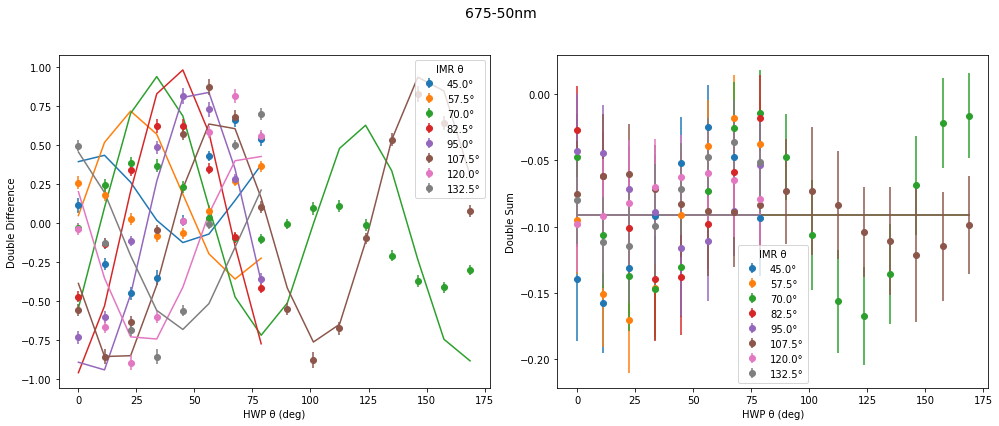

In [11]:
# Fittin for all parameters

p0 = {
    "wollaston": {"transmission_ratio": em_gain}, 
    "flc": {"phi": 2 * np.pi * delta_FLC, "delta_theta": rot_FLC},
    "optics": {"phi": 2 * np.pi * delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
    "image_rotator": {"phi": 2 * np.pi * delta_derot, "delta_theta": offset_derot},
    "hwp": {"phi": 2 * np.pi * delta_HWP, "delta_theta": offset_HWP},
    "lp": {"theta": theta_pol}
}

p0_values, p0_keywords = inst.parse_configuration(p0)
s_in = np.array([1, 0, 0, 0])
logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
    s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
    process_model=inst.process_model)
print("logl value: " + str(logl_value))

# TODO: Add an initial plot block here
# Plotting intial plot
updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)

# Step 5: Running minimize_system_Mueller_matrix iteratively

Before p0: {'wollaston': {'transmission_ratio': 1.2}, 'flc': {'phi': 3.141592653589793, 'delta_theta': 0}, 'optics': {'phi': 0.0, 'epsilon': 0, 'theta': 0}, 'image_rotator': {'phi': 2.0106192982974678, 'delta_theta': 0}, 'hwp': {'phi': 2.8337165735379934, 'delta_theta': -2.642}, 'lp': {'theta': 0}}
Iteration #: 1
logl_value: 1371.4467725395598
Best Fit Parameters: [ 1.12014281e+00  2.66754536e+00 -4.97422484e+00 -1.16353289e+00
  1.77258022e-04 -2.01170603e+00  2.17164051e+00 -4.99149593e+00
  2.89841568e+00  4.98175882e+00  3.30809484e+00]


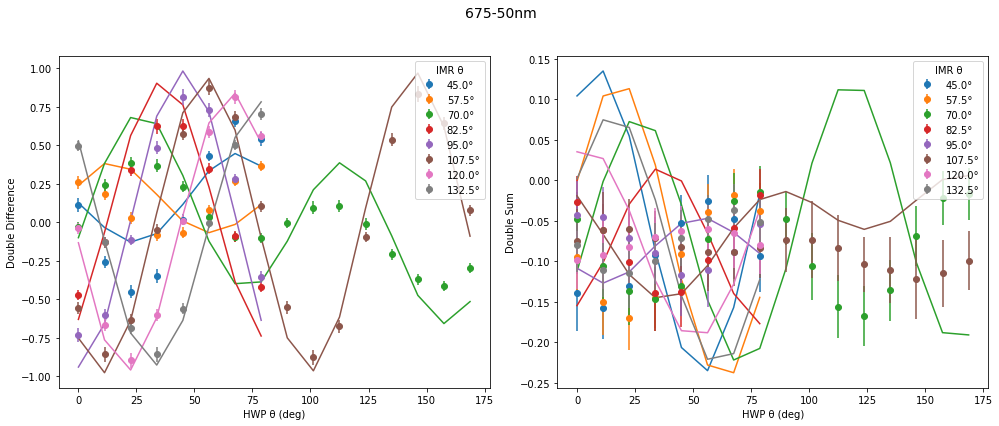

After p0: {'wollaston': {'transmission_ratio': 1.1201428055002212}, 'flc': {'phi': 2.6675453577889012, 'delta_theta': -4.9742248392270625}, 'optics': {'phi': -1.1635328885900535, 'epsilon': 0.0001772580220152412, 'theta': -2.01170602860428}, 'image_rotator': {'phi': 2.1716405110786257, 'delta_theta': -4.9914959275682556}, 'hwp': {'phi': 2.898415679877856, 'delta_theta': 4.981758816982083}, 'lp': {'theta': 3.30809483736026}}
Before p0: {'wollaston': {'transmission_ratio': 1.1201428055002212}, 'flc': {'phi': 2.6675453577889012, 'delta_theta': -4.9742248392270625}, 'optics': {'phi': -1.1635328885900535, 'epsilon': 0.0001772580220152412, 'theta': -2.01170602860428}, 'image_rotator': {'phi': 2.1716405110786257, 'delta_theta': -4.9914959275682556}, 'hwp': {'phi': 2.898415679877856, 'delta_theta': 4.981758816982083}, 'lp': {'theta': 3.30809483736026}}
Iteration #: 2
logl_value: 113.36640718690097
Best Fit Parameters: [ 1.17186909e+00  3.18005470e+00  3.99586805e+00 -2.20687162e+00
  1.4993159

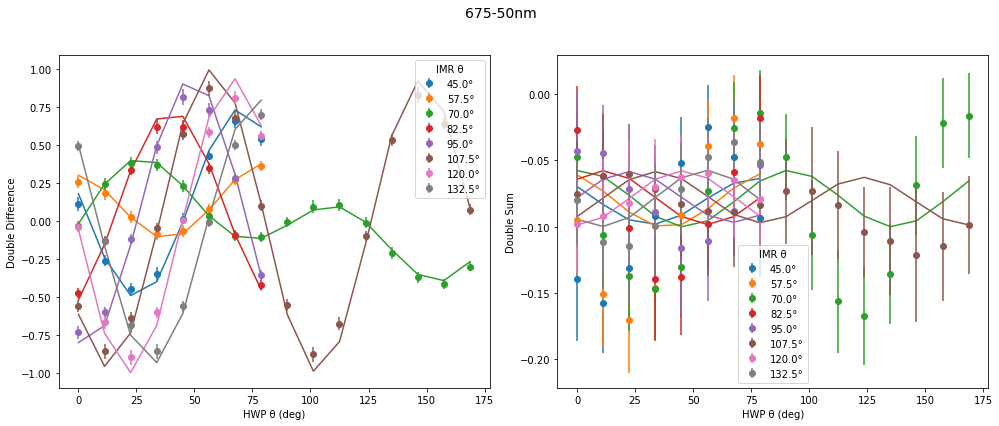

After p0: {'wollaston': {'transmission_ratio': 1.1718690905724451}, 'flc': {'phi': 3.1800546967782326, 'delta_theta': 3.9958680546810816}, 'optics': {'phi': -2.206871616884289, 'epsilon': 1.4993158999068129e-06, 'theta': 15.705832593530292}, 'image_rotator': {'phi': 1.998797333902663, 'delta_theta': -0.4321887359148585}, 'hwp': {'phi': 2.922196706844325, 'delta_theta': -4.3982891472307095}, 'lp': {'theta': -4.992196923382375}}
Before p0: {'wollaston': {'transmission_ratio': 1.1718690905724451}, 'flc': {'phi': 3.1800546967782326, 'delta_theta': 3.9958680546810816}, 'optics': {'phi': -2.206871616884289, 'epsilon': 1.4993158999068129e-06, 'theta': 15.705832593530292}, 'image_rotator': {'phi': 1.998797333902663, 'delta_theta': -0.4321887359148585}, 'hwp': {'phi': 2.922196706844325, 'delta_theta': -4.3982891472307095}, 'lp': {'theta': -4.992196923382375}}
Iteration #: 3
logl_value: 79.62342872728242
Best Fit Parameters: [ 1.19057065e+00  3.27346038e+00  4.99599679e+00 -1.29828363e+00
  2.19

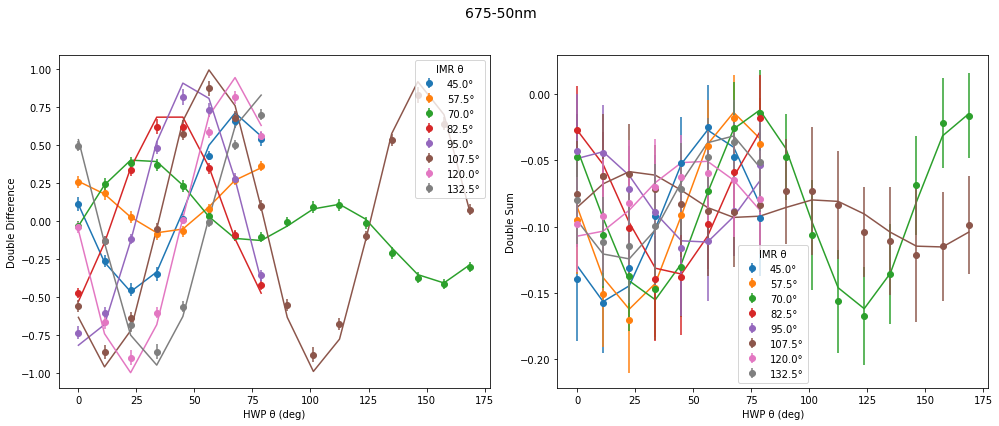

After p0: {'wollaston': {'transmission_ratio': 1.1905706520081578}, 'flc': {'phi': 3.2734603766600454, 'delta_theta': 4.995996785770492}, 'optics': {'phi': -1.2982836305304222, 'epsilon': 2.1951348998551494e-05, 'theta': 19.17368612339495}, 'image_rotator': {'phi': 2.0584591978966573, 'delta_theta': -4.257445505097511}, 'hwp': {'phi': 2.9256581947368243, 'delta_theta': -4.999577740029556}, 'lp': {'theta': -4.999968787279826}}
Before p0: {'wollaston': {'transmission_ratio': 1.1905706520081578}, 'flc': {'phi': 3.2734603766600454, 'delta_theta': 4.995996785770492}, 'optics': {'phi': -1.2982836305304222, 'epsilon': 2.1951348998551494e-05, 'theta': 19.17368612339495}, 'image_rotator': {'phi': 2.0584591978966573, 'delta_theta': -4.257445505097511}, 'hwp': {'phi': 2.9256581947368243, 'delta_theta': -4.999577740029556}, 'lp': {'theta': -4.999968787279826}}
Iteration #: 4
logl_value: 76.90837184354771
Best Fit Parameters: [ 1.18988756e+00  3.27574298e+00  4.99918419e+00 -1.27557117e+00
  1.0808

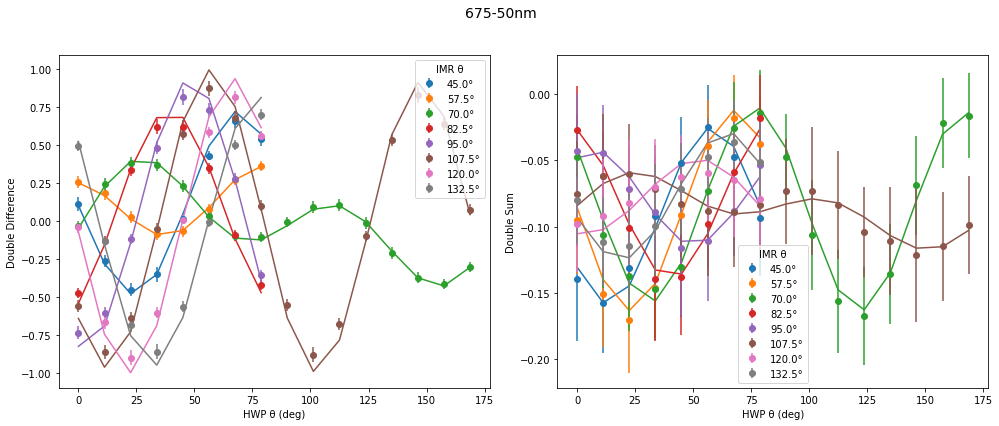

After p0: {'wollaston': {'transmission_ratio': 1.189887559876786}, 'flc': {'phi': 3.27574297571695, 'delta_theta': 4.999184191623117}, 'optics': {'phi': -1.2755711659871456, 'epsilon': 0.010808149774469675, 'theta': 18.942217082162237}, 'image_rotator': {'phi': 2.0513245494458165, 'delta_theta': -4.811294609008378}, 'hwp': {'phi': 2.916811178967067, 'delta_theta': -4.754426680652935}, 'lp': {'theta': -3.6234174817082394}}
Before p0: {'wollaston': {'transmission_ratio': 1.189887559876786}, 'flc': {'phi': 3.27574297571695, 'delta_theta': 4.999184191623117}, 'optics': {'phi': -1.2755711659871456, 'epsilon': 0.010808149774469675, 'theta': 18.942217082162237}, 'image_rotator': {'phi': 2.0513245494458165, 'delta_theta': -4.811294609008378}, 'hwp': {'phi': 2.916811178967067, 'delta_theta': -4.754426680652935}, 'lp': {'theta': -3.6234174817082394}}
Iteration #: 5
logl_value: 74.52598374656009
Best Fit Parameters: [ 1.19058076e+00  3.27510686e+00  4.99989699e+00 -1.29328097e+00
  1.58969468e-03

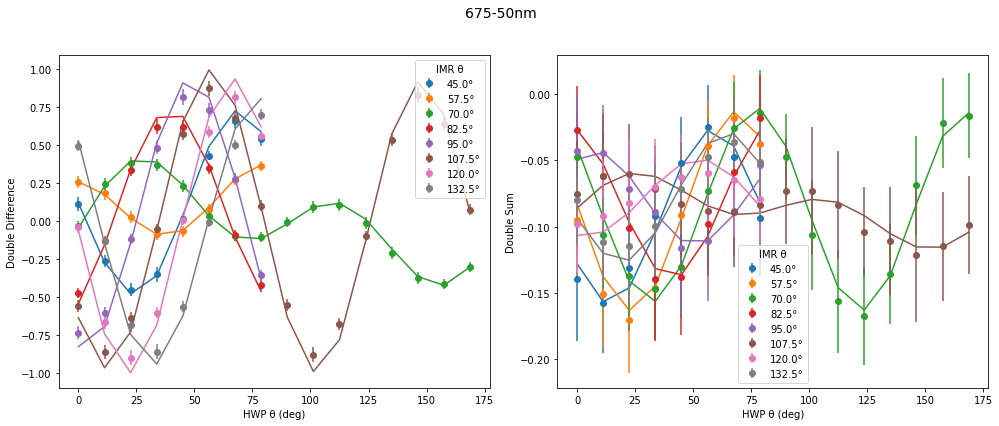

After p0: {'wollaston': {'transmission_ratio': 1.1905807561452284}, 'flc': {'phi': 3.2751068569534496, 'delta_theta': 4.999896993221881}, 'optics': {'phi': -1.293280974177875, 'epsilon': 0.0015896946817393932, 'theta': 18.48930120835142}, 'image_rotator': {'phi': 2.0412240651947196, 'delta_theta': -4.985674802605541}, 'hwp': {'phi': 2.9206802863419714, 'delta_theta': -4.6172954829338035}, 'lp': {'theta': -2.781636838584495}}
Before p0: {'wollaston': {'transmission_ratio': 1.1905807561452284}, 'flc': {'phi': 3.2751068569534496, 'delta_theta': 4.999896993221881}, 'optics': {'phi': -1.293280974177875, 'epsilon': 0.0015896946817393932, 'theta': 18.48930120835142}, 'image_rotator': {'phi': 2.0412240651947196, 'delta_theta': -4.985674802605541}, 'hwp': {'phi': 2.9206802863419714, 'delta_theta': -4.6172954829338035}, 'lp': {'theta': -2.781636838584495}}
Iteration #: 6
logl_value: 74.38199975503221
Best Fit Parameters: [ 1.19107686e+00  3.27420996e+00  4.99999972e+00 -1.29652118e+00
  1.254820

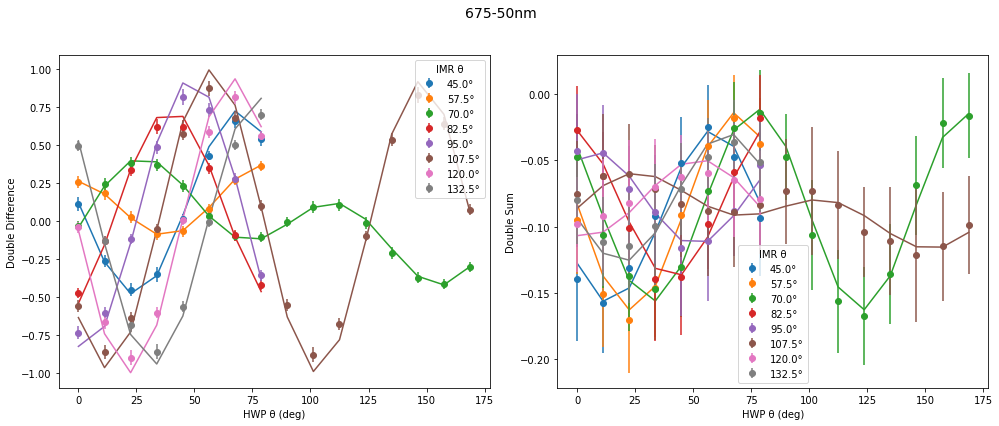

After p0: {'wollaston': {'transmission_ratio': 1.1910768600649848}, 'flc': {'phi': 3.2742099617263074, 'delta_theta': 4.999999721904018}, 'optics': {'phi': -1.2965211813604989, 'epsilon': 0.0012548202483441979, 'theta': 18.44140703635646}, 'image_rotator': {'phi': 2.040070732467635, 'delta_theta': -4.999999108202001}, 'hwp': {'phi': 2.9213357068488017, 'delta_theta': -4.999889285082107}, 'lp': {'theta': -3.472404345551918}}


In [12]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])
bounds = [ 
    (0, 2),  # em_gain
    (0.4 * 2 * np.pi, 0.6 * 2 * np.pi),  # delta_FLC
    (-5, 5),  # rot_FLC
    (-0.5 * 2 * np.pi, 0.5 * 2 * np.pi),  # delta_opts
    (0, 0.1),  # epsilon_opts
    (-90, 90),  # rot_opts
    ((delta_derot - delta_derot * 0.1) * 2 * np.pi, (delta_derot + delta_derot * 0.1) * 2 * np.pi),  # delta_derot
    (-5, 5),  # offset_derot
    ((delta_HWP - delta_HWP * 0.1) * 2 * np.pi, 0.5 * 2 * np.pi),  # delta_HWP
    (-5, 5),  # offset_HWP
    (-5, 5)  # theta_pol
]

# Counters for iterative fitting
iteration = 1
previous_logl_value = 1000000
new_logl_value = 0

while abs(previous_logl_value - new_logl_value) > 0.01 * abs(previous_logl_value):
    print("Before p0: " + str(p0))
    if iteration > 1: 
        previous_logl_value = new_logl_value
    result, new_logl_value = inst.minimize_system_mueller_matrix(p0, system_mm, 
        interleaved_values, interleaved_stds, configuration_list, s_in = s_in,
        process_dataset = inst.process_dataset, 
        process_errors = inst.process_errors, 
        process_model = inst.process_model, bounds = bounds)
    
    # Print statements
    print("Iteration #: " + str(iteration))
    print("logl_value: " + str(new_logl_value))
    print("Best Fit Parameters: " + str(result.x))

    # Making a plot
    updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
    model = inst.model(result.x, p0_keywords, updated_system_mm, configuration_list, 
    process_model = inst.process_model)

    inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
        configuration_list, wavelength = wavelength_string)

    # Updating p0 for next time
    inst.update_p0(p0, result.x)
    print("After p0: " + str(p0))

    iteration += 1

# Step 6: Plot model with best fit

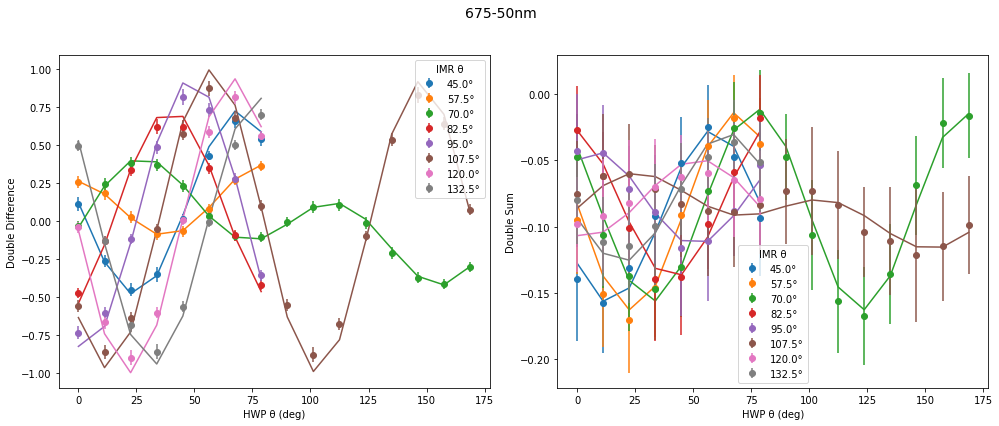

In [13]:
# Generate model with p0 keywords but scipy minimized results
# print(result.x)
# print(p0_keywords)

# Manually adjusting for a good fit
dichroic_phi = 0 # (waves)
dichroic_theta = 0 # (degrees)
# result.x = [2 * np.pi * dichroic_phi, dichroic_theta]

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)